In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from chromatic import *
import emcee
from scipy.stats import chi2
from scipy.stats import norm
import corner

In [2]:
TOI270d_spec = pd.read_csv('Mikal-Evans_data_noTESS.csv')
data_flux = TOI270d_spec['depth'] /100
data_err = (TOI270d_spec['upper']-TOI270d_spec['depth']) /100

# data_err = 46.05e-6
# data_wave = (data_wave_low + 0.009) * u.micron
data_wave = np.array(TOI270d_spec['wavelength']) * u.micron

<ErrorbarContainer object of 3 artists>

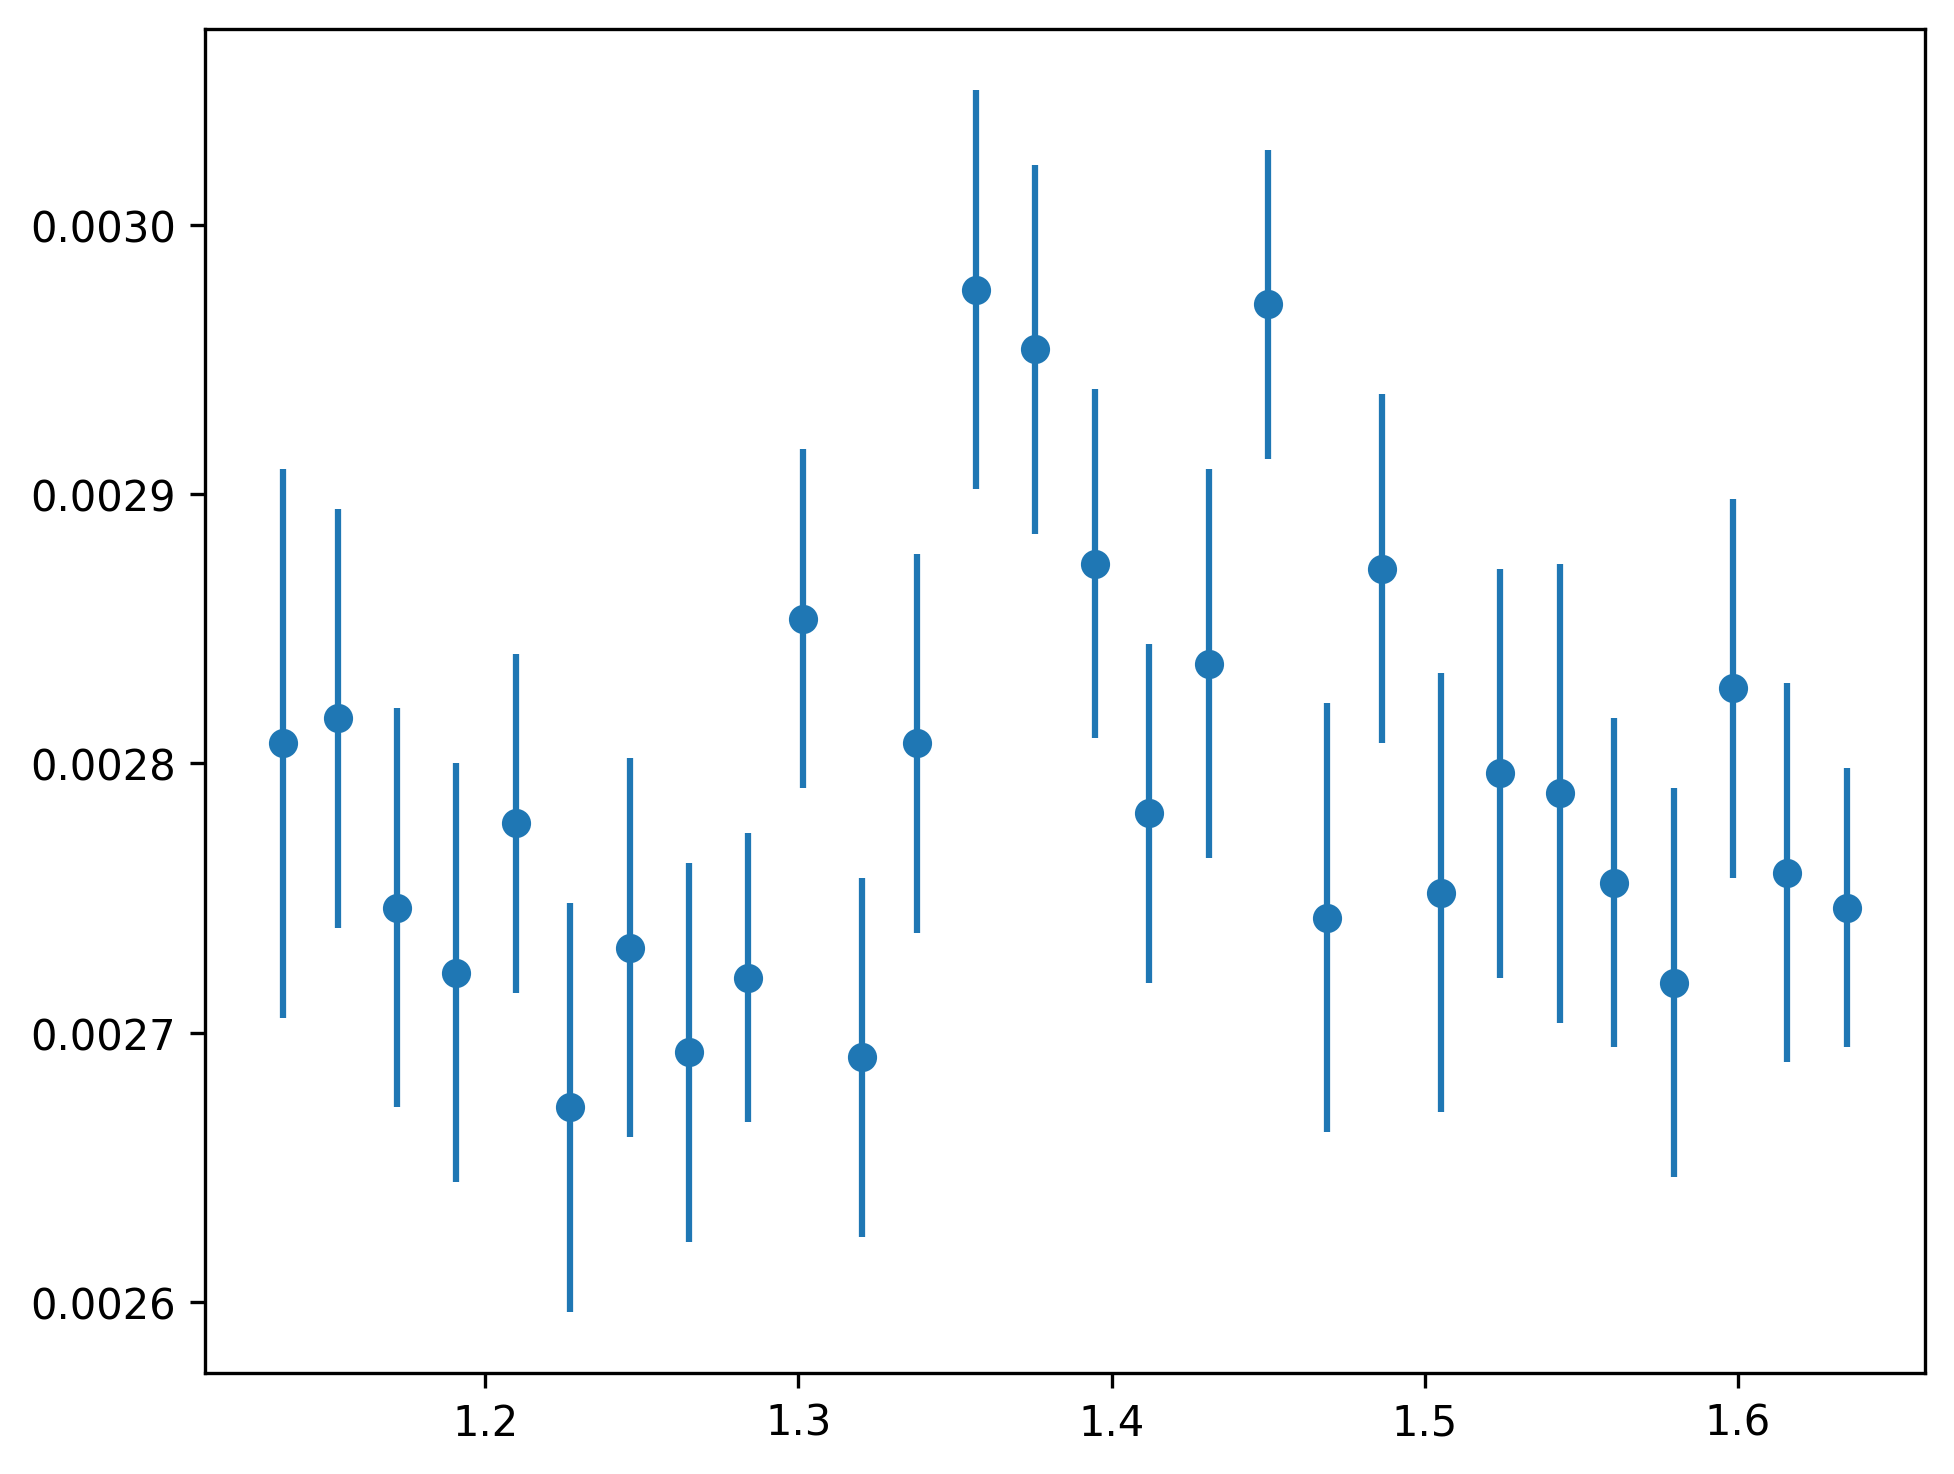

In [3]:
plt.errorbar(data_wave,data_flux,data_err,fmt='o')

In [31]:
w = np.linspace(0.8,1.0,100)* u.micron
Fspot = get_phoenix_photons(temperature=float(3100), wavelength=w, logg=4.5, metallicity=0.00)[1]
Famb = get_phoenix_photons(temperature=float(4000), wavelength=w, logg=4.5, metallicity=0.0)[1]

In [24]:
# Fspot = 
# Famb = 
contrast = 1.0-(Fspot/Famb)

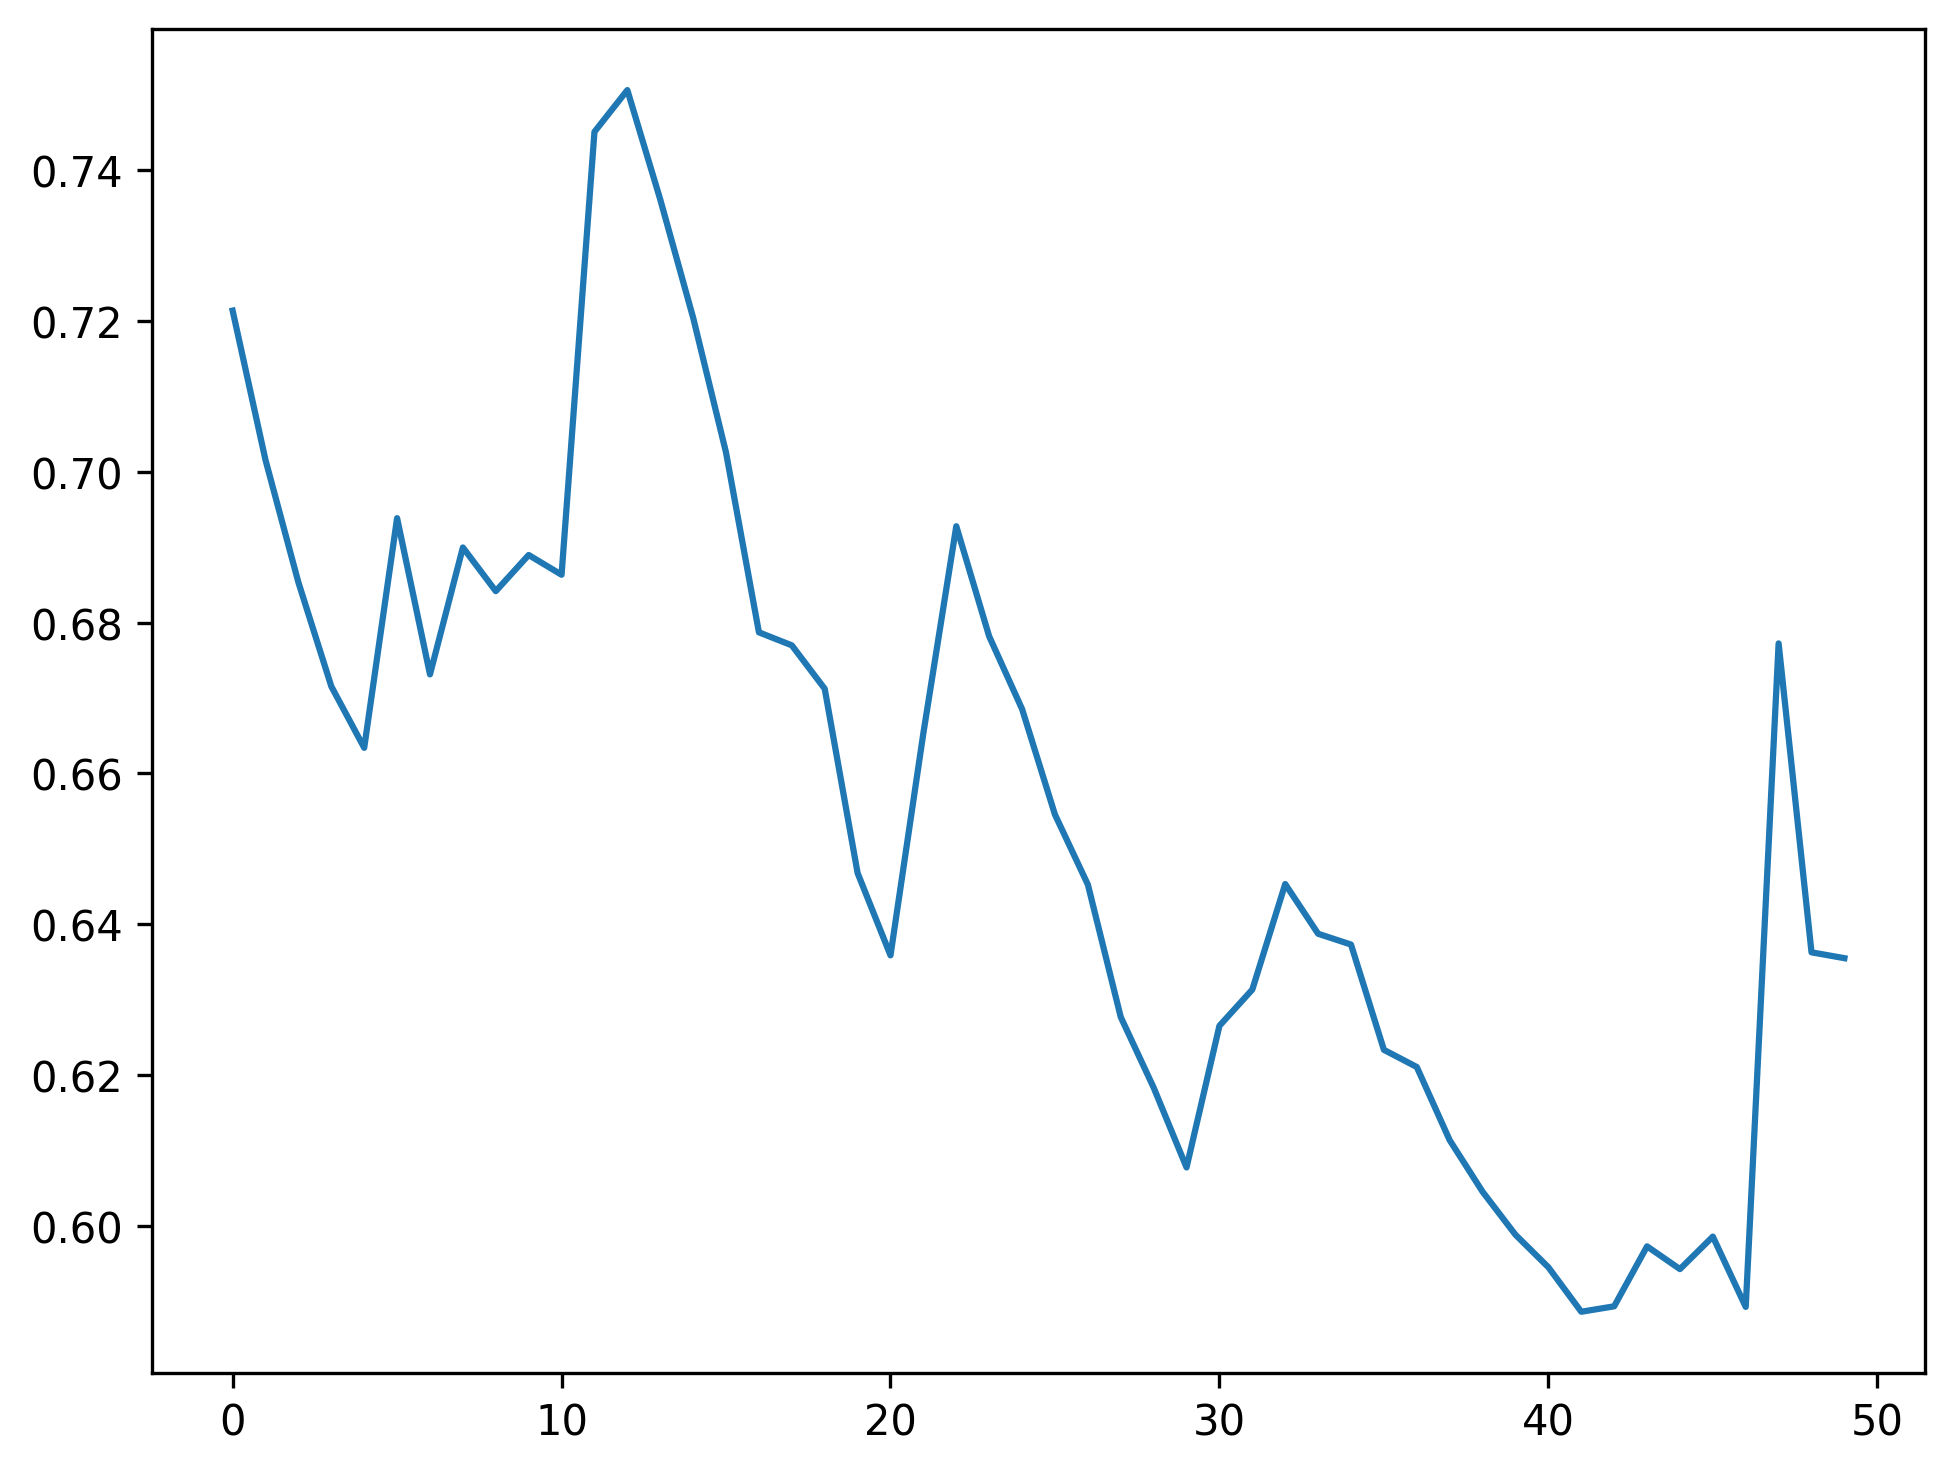

In [34]:
plt.plot(contrast)

In [4]:
def spot_transmission_model(params,w,err = 1e-5,
                            plot=False,N_transits=1,
                            **kwargs):
    
    rp_rstar, fspot, Tspot, Tamb = params
    transit_depth = rp_rstar**2
    err = err/np.sqrt(N_transits)
        
    s_spot = get_phoenix_photons(temperature=float(Tspot), wavelength=w, logg=4.6, metallicity=0.0)
    s_amb = get_phoenix_photons(temperature=float(Tamb), wavelength=w, logg=4.6, metallicity=0.0)
    
    flux_ratio = s_spot[1]/s_amb[1]
    top = 1. # technically this is only if f_tra = 0
    bottom = (1. - fspot) + fspot * flux_ratio
    d_spot = ((top / bottom) - 1.) * transit_depth
    
    model_spec = (transit_depth + d_spot)#*1e6
    # model_spec = d_spot*1e6
    noisy_spec = np.random.normal(model_spec,err*1e6) 
    
    # if plot:
    #     plt.figure(figsize=(5,3))
    #     plt.plot(w,model_spec,color='k',label='Input model')
    #     plt.errorbar(w,noisy_spec,yerr = err,fmt='o',color='blue',alpha=0.75,label='Simulated observation')
    #     plt.legend()
    
    return noisy_spec, model_spec

In [14]:
def lnprob(parameters=None,**kwargs):

    rp_rstar,f_spot,T_spot,T_amb = parameters

    if (0.0<=f_spot<=1.0) and (2300.0<=T_spot<=8000.0) and (2300.0<=T_amb<=8000.0):

        ln_like=0.0
        
        "Teff likelihood"
        Teff_model = (f_spot*(T_spot**4.) + (1.-f_spot)*(T_amb**4.))**(1./4.)    
        chisq_Teff = (Teff_data - Teff_model)**2./(T_err)**2.
        err_weight_Teff = 1./np.sqrt(2.*np.pi*(T_err))
        ln_like += (err_weight_Teff - 0.5*chisq_Teff)
        
        "Transmission likelihood"
        _, model = spot_transmission_model(params = parameters, w = data_wave,err = data_err)
        chisq = np.nansum((data_flux-model)**2/(data_err**2))
        err_weight = np.nansum(1./np.sqrt(2.*np.pi*(data_err)))
        ln_like += (err_weight - 0.5*chisq)
        
    else:
        ln_like = -np.inf

    return ln_like

In [15]:
def do_mcmc(label='oops you didnt label your samples :sadface:',
            nsteps=100,burnin=25,ndim=4,nwalkers=100,**kwargs):
    
    # these are initial parameters
    rp_rstar_init = np.random.uniform(rprstar-0.0005, rprstar+0.0005, nwalkers)
    fspot_init = np.random.uniform(0.02, 0.3, nwalkers)
    Tspot_init = np.random.uniform(2301., Teff_data-400, nwalkers)
    Tamb_init = np.random.uniform(Teff_data, Teff_data+200, nwalkers)
    p0 = np.transpose([rp_rstar_init, fspot_init, Tspot_init, Tamb_init])

    # set up file saving for the samples when finished
    filename = f"{label}.h5"
    backend = emcee.backends.HDFBackend(filename)
    backend.reset(nwalkers, ndim)
    # Initialize and run the sampler
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, backend=backend)
    result = sampler.run_mcmc(p0, nsteps,store=True)
    samples = sampler.chain[:, burnin:, :].reshape((-1, ndim)).T

    for i in range(len(samples)):
        tau_f = emcee.autocorr.integrated_time(samples[i])
        print('(Nsteps-burnin)*nwalkers/tau=',(nsteps-burnin)*nwalkers/tau_f)
    
    return samples

In [16]:
nsteps = 5000
ntransits = 1
planet_name = 'TOI 270d'
Teff_data = 3500.0
T_err = 100.0
rprstar = 0.052

In [17]:
samples = do_mcmc(label = f'TOI 270d TLSE Model',
                  nsteps = nsteps, burnin = int(0.25*nsteps))

(Nsteps-burnin)*nwalkers/tau= [1123.52205182]
(Nsteps-burnin)*nwalkers/tau= [418.39956904]
(Nsteps-burnin)*nwalkers/tau= [397.33731036]
(Nsteps-burnin)*nwalkers/tau= [1251.86196054]


[0.04496234 0.04690998 0.04874559]
[0.23188883 0.31306131 0.40319262]
[2371.86174041 2540.34362444 2814.24621224]
[3577.74512    3724.08190084 3888.59640583]


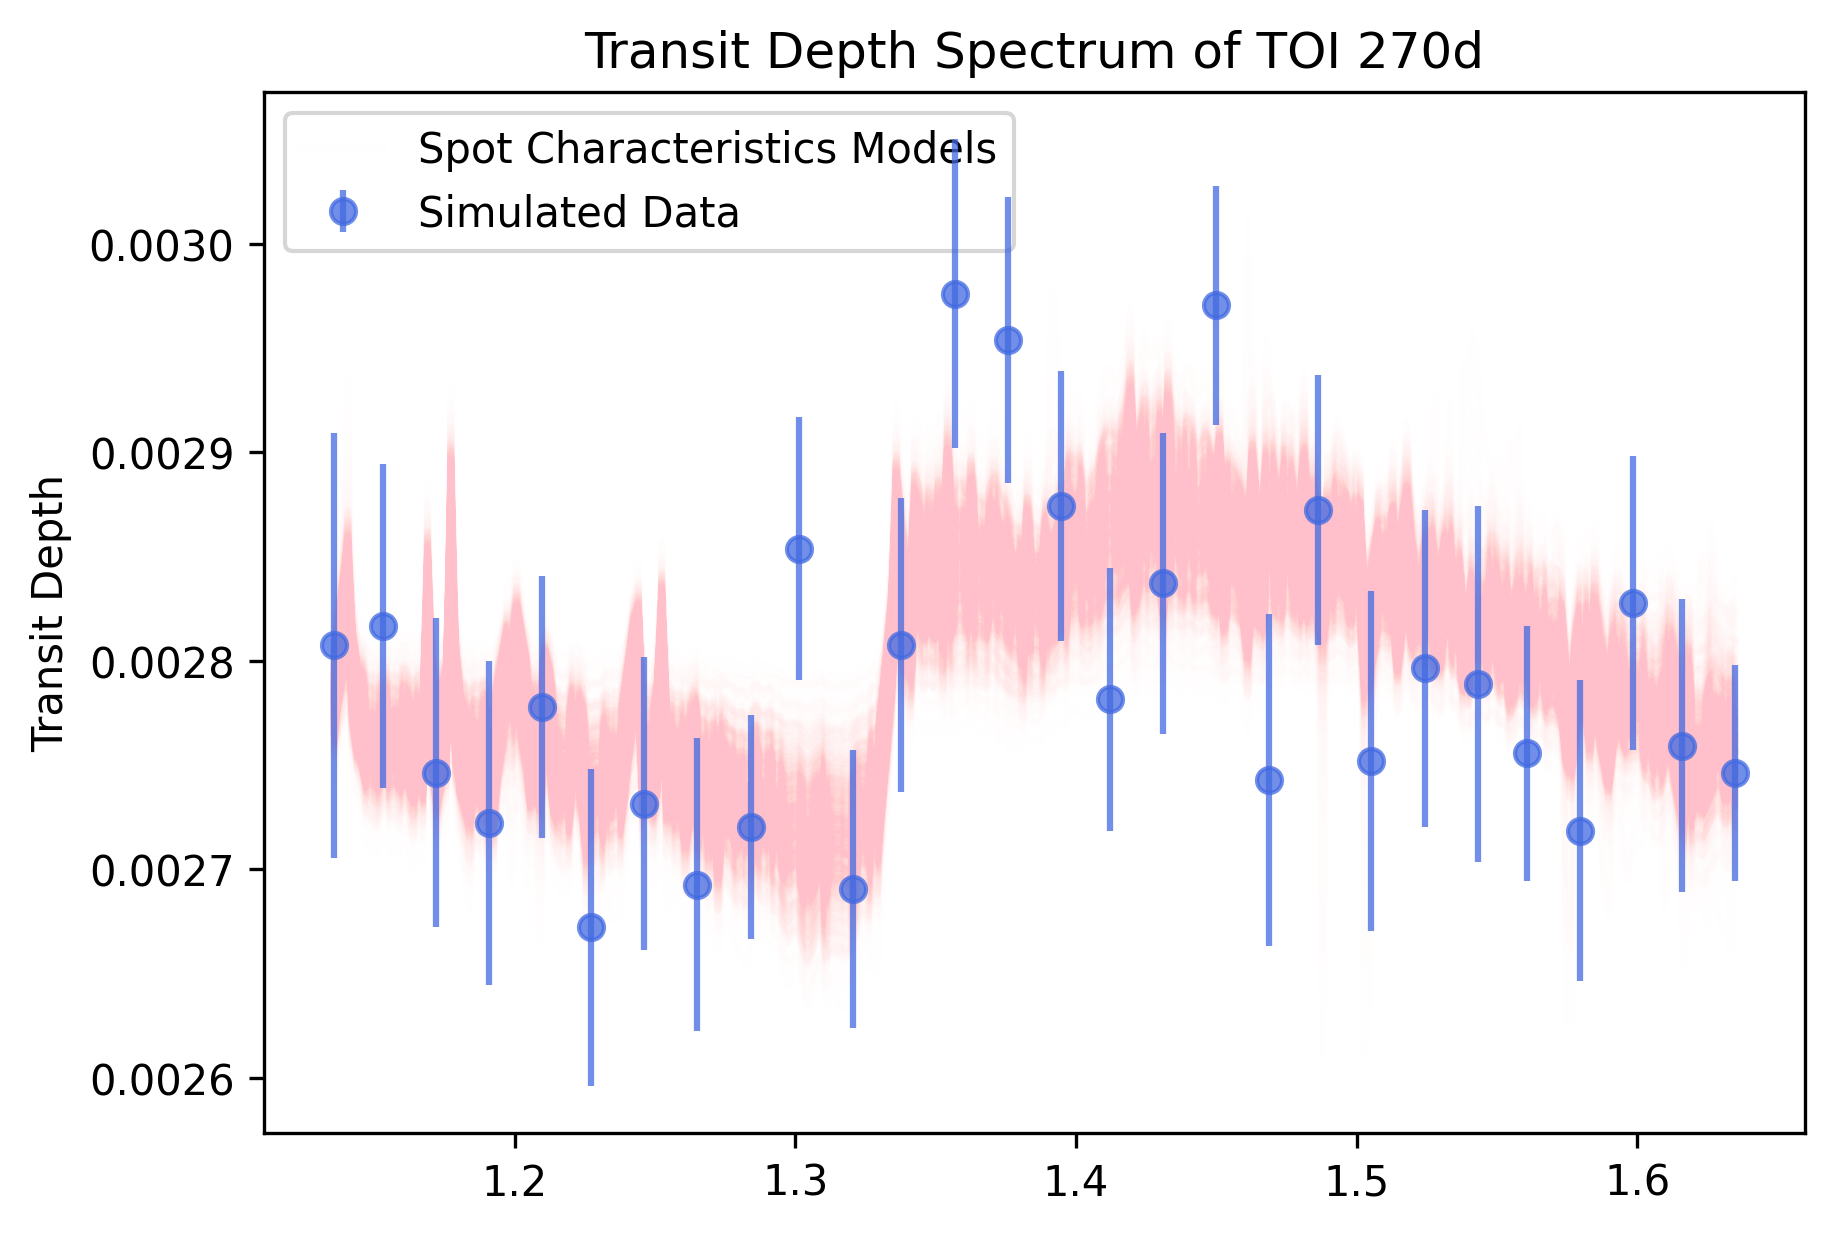

In [18]:
rp_sam, fspot_sam, Tspot_sam, Tphot_sam = samples
for sample in samples:
    percentiles = np.percentile(sample,[16.,50.,84.])
    print(percentiles)

hires_wave = np.linspace(np.min(data_wave),np.max(data_wave),300)

fig,axs = plt.subplots(1,1,figsize=(6,4),sharex=True)
axs.set_title(f'Transit Depth Spectrum of {planet_name}')
axs.errorbar(data_wave,data_flux,yerr=data_err,fmt='o',zorder=100,color='royalblue',alpha=0.75,label='Simulated Data')
# axs[0].plot(hires_wave,hires_bestmodel,zorder=10,color='darkred',linewidth=0.5)
axs.set_ylabel('Transit Depth')
axs[0].set_ylim(0.0025,0.0032)
axs[0].legend(fontsize=10)
axs[1].set_title('1000 samples (0.5% of the models)')
axs[1].set_ylabel('data-model/uncertainty')
axs[1].set_xlabel('Wavelength (micron)')
# axs[1].set_ylim(0,20)
axs[1].scatter(data_wave,np.abs((data_flux-np.median(data_flux))/data_err),color='k',s=3)

for k in range(0,1000):
        
    j = np.random.randint(low=0,high=(len(Tspot_sam)-1))
    these_parameters = [rp_sam[j],fspot_sam[j],Tspot_sam[j],Tphot_sam[j]]
    _,hires_model = spot_transmission_model(params = these_parameters, w = hires_wave)
    
    if k == 0:
        axs.plot(hires_wave,hires_model,c='pink',alpha=0.01,zorder=1,label='Spot Characteristics Models') # this will be the input wavelength from the order in question
    
    axs.plot(hires_wave,hires_model,c='pink',alpha=0.01,zorder=1) # this will be the input wavelength from the order in question

axs.legend()
plt.savefig(f'{planet_name}_tlse_sim.pdf')

/Users/wiwa8630/opt/anaconda3/envs/fleckopy/lib/python3.10/site-packages/corner/core.py:133: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(


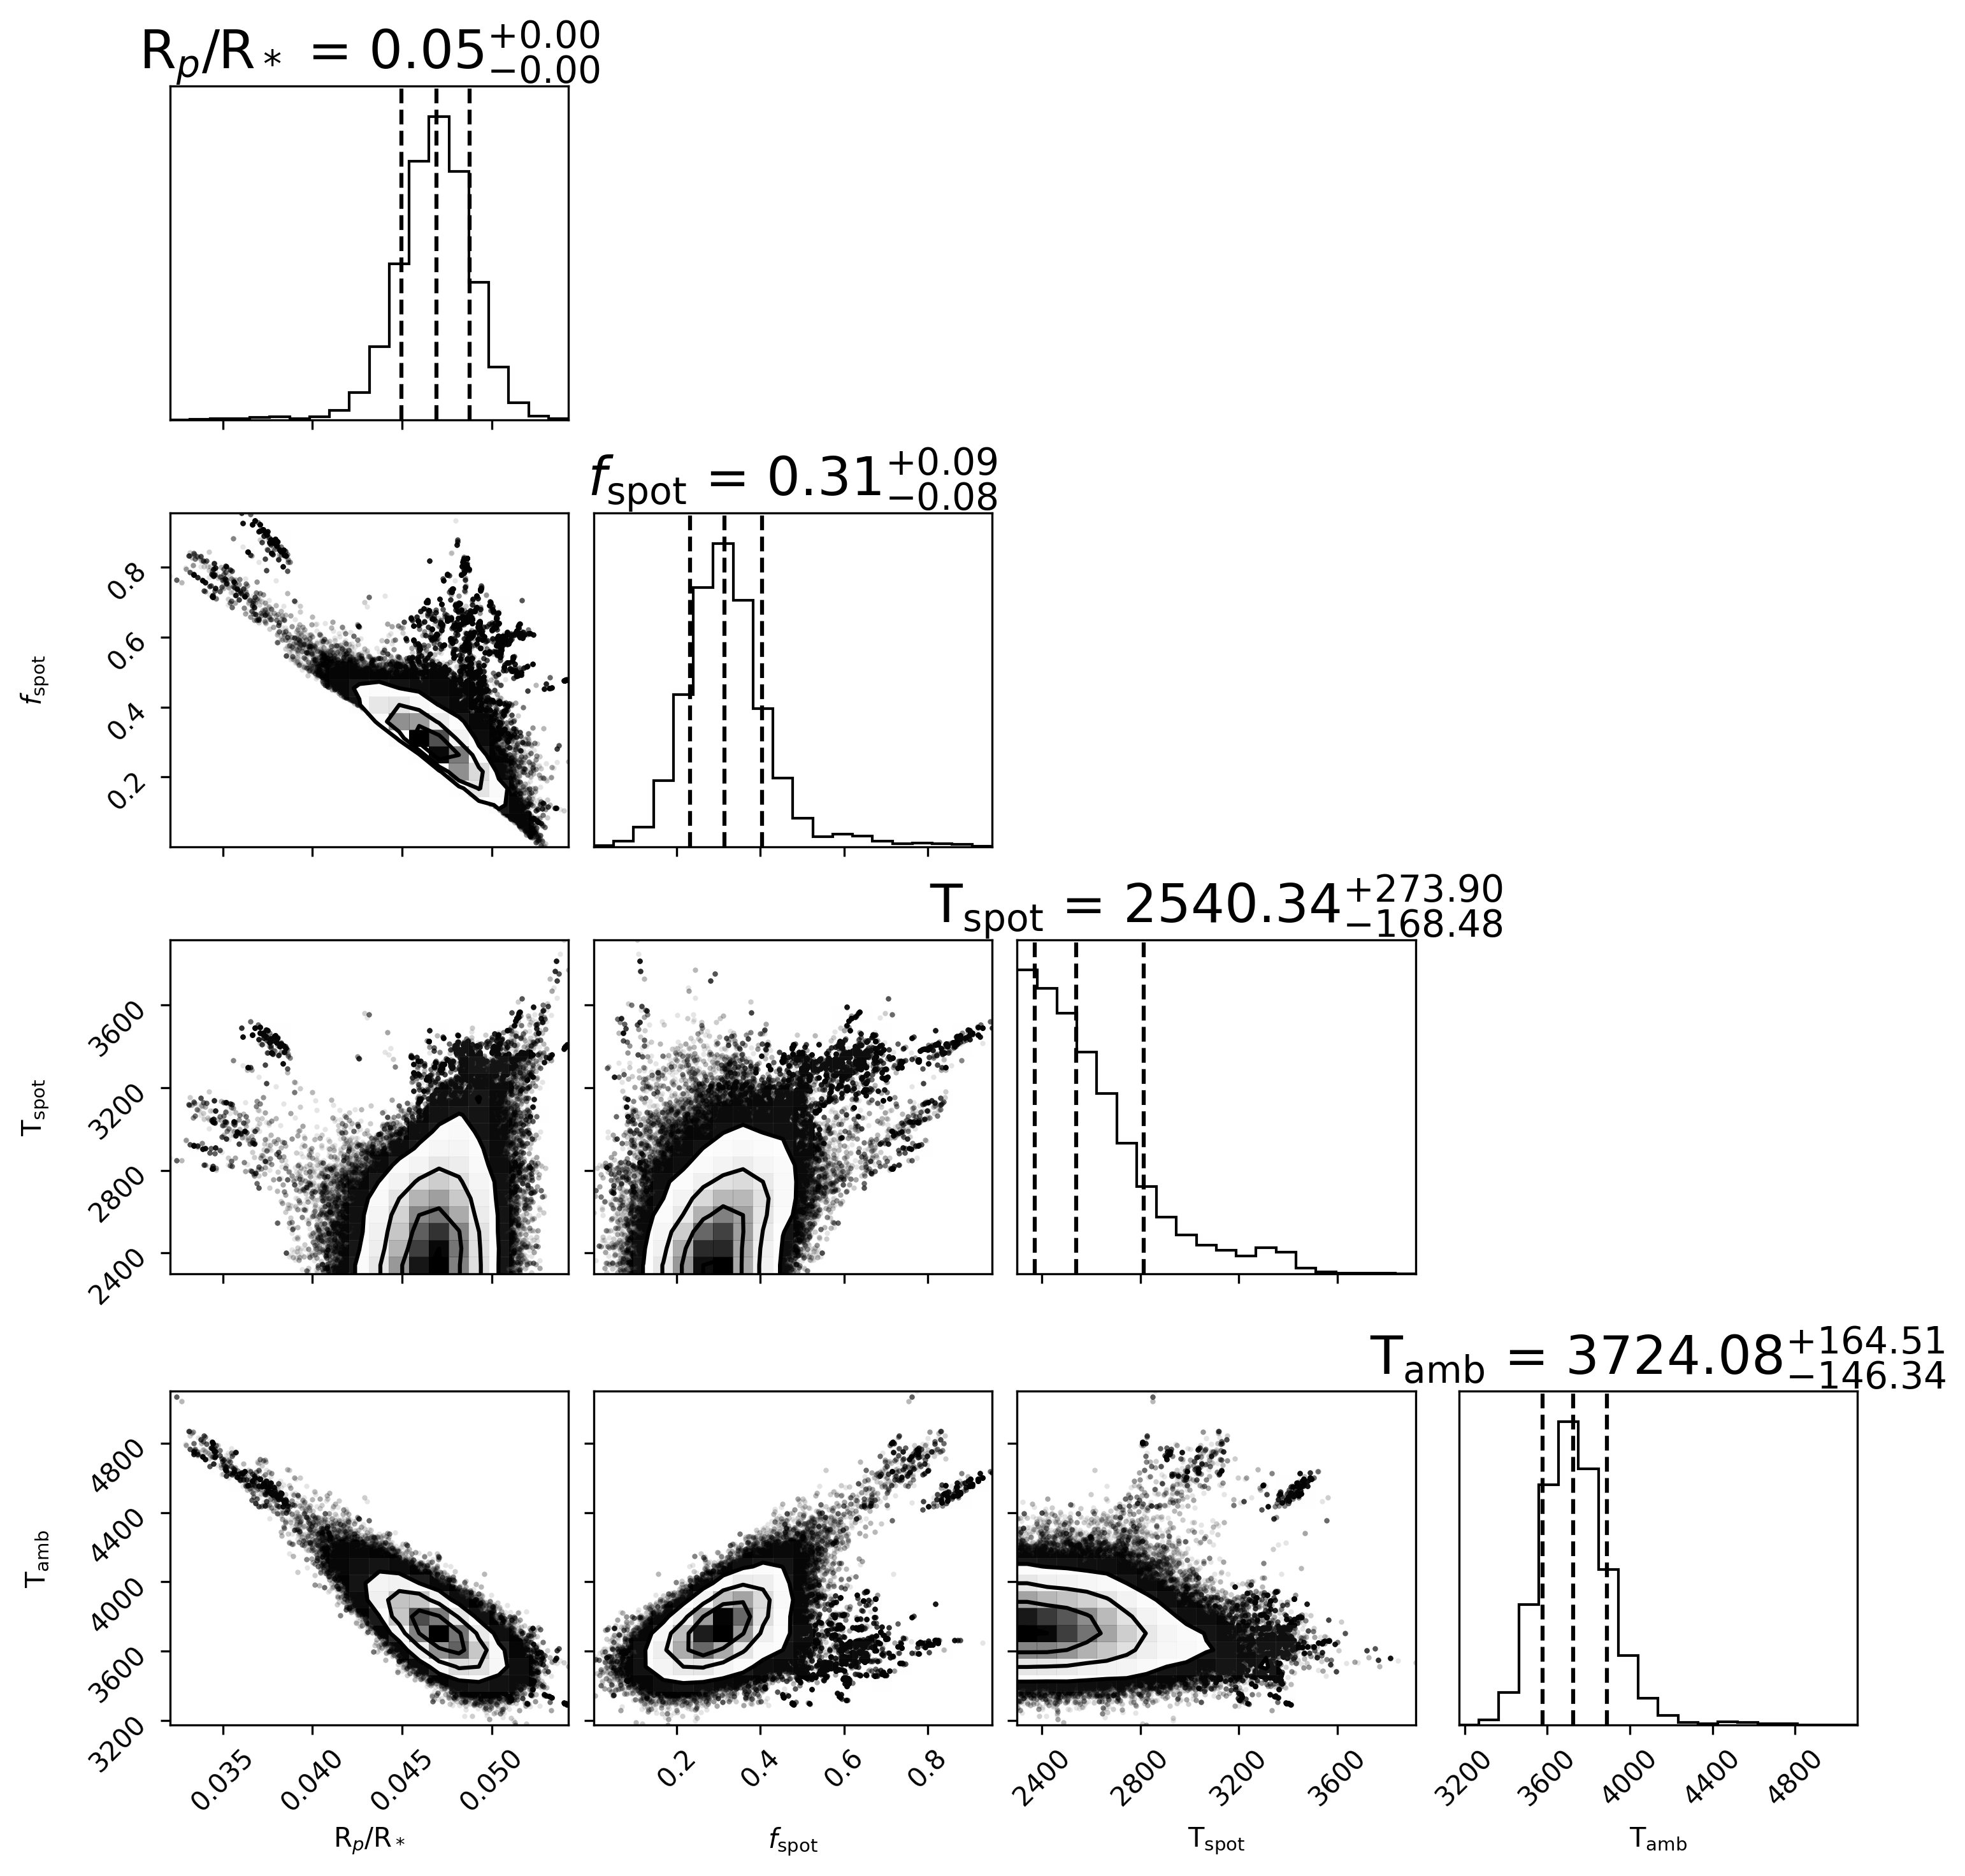

In [21]:
variable_names = [r'R$_p$/R$_*$',r'$f_{\rm spot}$',r'T$_{\rm spot}$',r'T$_{\rm amb}$']
#make the corner plot
figure = corner.corner(samples.T, labels=variable_names,
                       quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, title_kwargs={"fontsize": 20})

# Extract the axes, loop through to set all the limits
axes = np.array(figure.axes).reshape((4, 4))
for yi in range(4):
    ax = axes[yi, 0]
    # ax.set_xlim(0.220,0.225)
    
    # ax.axvline(True_params[0],color='red')
    ax = axes[1, 1]
    # ax.set_xlim(0.0,0.30)
    # ax.axvline(True_params[1],color='red')
    ax = axes[2, 1]
    # ax.set_xlim(0.0,0.30)
    # ax.axvline(True_params[1],color='red')
    ax = axes[3, 1]
    # ax.axvline(True_params[1],color='red')
    # ax.set_xlim(0.0,0.30)
    
    ax = axes[2, 2]
    # ax.set_xlim(2500,3600)
    # ax.axvline(True_params[2],color='red')
    ax = axes[3, 2]
    # ax.set_xlim(2500,3600)
    # ax.axvline(True_params[2],color='red')
    
    ax = axes[3, 3]
    # ax.set_xlim(3200,4000)
    # ax.axvline(True_params[3],color='red')
    
    
plt.savefig('optimistic_corner.png')